In [1]:
from lib.abstract_torch import get_device, get_optimizer, get_loss
from lib.benchmark_generator import PermutedMNIST
from lib.models import ANN
from lib.train import train
from lib.test import test
from lib.visualize import vizualize_loss_hists, visualize_accs_matrix, visualize_avg_acc_curve

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from avalanche.training.supervised import EWC
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/data"

In [3]:
device = get_device()

## Set parameters

In [4]:
# Benchmark parameter
num_tasks = 10
train_percentage = 0.8

# EWC parameter
ewc_lambda = 400

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 250
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Hyperparameters
num_epochs = 3
lr = 1e-3

## Reproducibility

In [5]:
random_seed = 88

## Get p-MNIST benchmark

In [6]:
benchmark = PermutedMNIST(n_experiences=num_tasks, train_percentage=train_percentage, difficulty="easy")

## Define model

In [7]:
model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

## Train with EWC

In [8]:
optimizer = get_optimizer(optimizer_name, model)

In [9]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True, trained_experience = True),
    loggers=[InteractiveLogger()]
)

ewc = EWC(
    model, optimizer, criterion=get_loss(loss_name), ewc_lambda=ewc_lambda,
    train_mb_size=batch_size, train_epochs=num_epochs, eval_mb_size=batch_size, evaluator=eval_plugin,
    device=device
)

In [10]:
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    print("Data in this experience: ", len(experience.dataset))

Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  2
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  3
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  4
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  5
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  6
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  7
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  8
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Data in this experience:  48001
Start of experience:  9
Current Classes:  [0, 1, 2, 3, 

In [11]:
results = []

for experience in benchmark.train_stream :
    ewc.train(experience)
    results.append(ewc.eval(benchmark.test_stream))

-- >> Start of training phase << --
0it [00:00, ?it/s]

100%|██████████| 376/376 [00:05<00:00, 69.02it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9072
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 376/376 [00:05<00:00, 70.67it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9606
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 376/376 [00:05<00:00, 72.47it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9695
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:01<00:00, 76.94it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9667
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 79/79 [00:00<00:00, 80.50it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_A

## Visualize results

In [12]:
test_accs_matrix = np.zeros((num_tasks,num_tasks))
for i,r in enumerate(results) :
    for j in range(num_tasks) :
        test_accs_matrix[i][j] = r[f'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{j}']*100

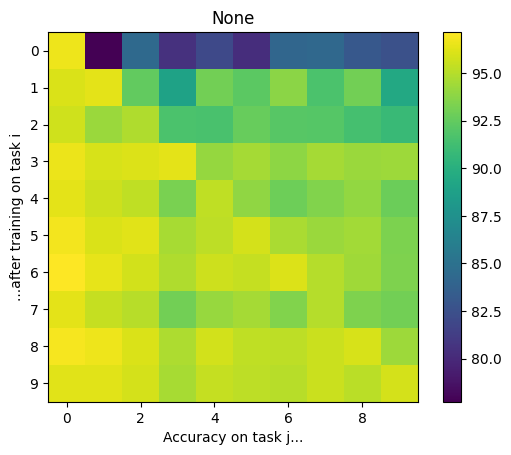

In [13]:
visualize_accs_matrix(test_accs_matrix)

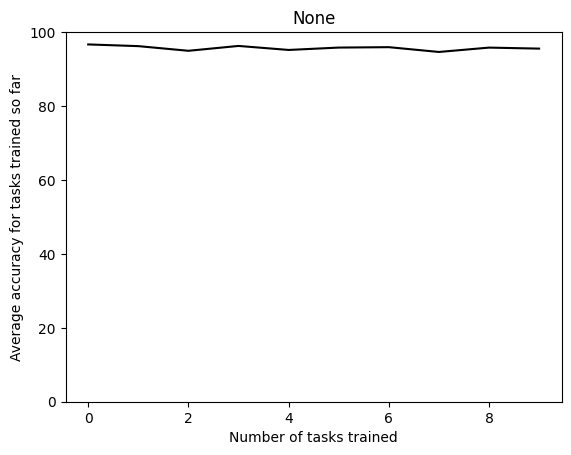

In [14]:
visualize_avg_acc_curve(test_accs_matrix)